# What, where, when?
Knowing where and when to point your telescope is an important part of astronomy. As interesting sources rise and set at different times around the Earth, having an understanding of astronomical coordinate systems is important, especially when submitting observing proposals. In this notebook we'll go over the basics, and look at how you can make these kind of calculations in `python`.

## Right Ascension and Declination
First and foremost, we measure the position of an astronomical object in Right Ascension (RA, or $\alpha$) and Declination (Dec, or $\delta$). This co-ordinate system is based around the rotation of the Earth; the North Celestial Pole is defined along the rotational axis of the Earth in the Northern Hemisphere ($\alpha = 0^\circ, \delta=90^\circ$), and the Celestial Equator $\delta=0$ is defined by the Earth's equator. Essentially, we have just projected latitude and longitude onto a disant 'Celestial Sphere'. This is depicted in the following image that I got from this web address [here](https://voyages.sdss.org/preflight/locating-objects/ra-dec/) (all credit to the authors).

![pre-flight-celestial-sphere.jpg](pre-flight-celestial-sphere.jpg)

The Earth rotates within this 'Celestial Sphere', so although most sources have an (almost) constant position in RA and Dec, when you stare directly up from the Earth, RA is constantly drifting overhead, and changing with time. This is why RA is often measured in hours, minutes, and seconds. As there are $360^\circ$ in a circle, and the Earth takes (almost) 24 hours to rotate, $1h = 15^\circ$, which minutes being 1/60th of an hour, and seconds being 1/60th of a minute.

This is _not_ to be confused with degrees, arcminutes, and arcseconds, which are often used to descibe Dec. An arcminute is 1/60th of a degree, and an arcsecond 1/60th of an arcminute.

Let's expand on this using some code. We'll be using the `astropy.coordinates` module for this. There is plenty of documentation on all the fun things you can do with `astropy` coords, some of it [here](https://docs.astropy.org/en/stable/coordinates/). Do refer to the proper documentation, this notebook only scratches the surface. That bein said, run the code below:

In [1]:
from astropy.coordinates import SkyCoord

##pick an RA,Dec in degrees
ra, dec = 50.67, -30.72

##create a SkyCoord object based on those coords
##tell the SkyCoord Class that we are using degrees
coord = SkyCoord(ra, dec, unit='deg')

print(type(coord.ra))
print(coord.ra, coord.dec)

<class 'astropy.coordinates.angles.Longitude'>
50d40m12s -30d43m12s


You should see that the `SkyCoord` class has two attributes, `ra` and `dec`, and that they are not simple floats, but classes themselves. Furthermore, when printing, they both default to outputting degrees, arcminutes, arcseconds. There are multiple ways to output the values, such as:

In [2]:
print(coord.ra.hms)
print(coord.ra.dms)
print(coord.ra.deg)
print(coord.ra.rad)

hms_tuple(h=3.0, m=22.0, s=40.800000000002115)
dms_tuple(d=50.0, m=40.0, s=12.000000000006139)
50.67
0.8843583319855268


`astropy` has done this to give you the greatest amount of flexibility possible, as well as when you pass a `SkyCoord` into other functions, the units are internally consitent. It does mean however you have to learn how to access value if you just want to get a float out, which can be annoying at the start. It's worth the effort in the end (I promise).

## <font color='blue'>Exercise 4.1</font>

You can also input a range of coordinates at once, as an array. Trying inputting 10 RA,Dec values into `SkyCoord`, using `numpy.arange` to create the RA,Dec values. `print` the results and make sure you understand what units are being displayed.

In [3]:
import numpy as np
ras = np.arange(40,60,2)
decs = np.arange(-40,-20,2)

coords = SkyCoord(ras,decs,unit='deg')

print(coords.ra.deg)
print(coords.dec.deg)

[40. 42. 44. 46. 48. 50. 52. 54. 56. 58.]
[-40. -38. -36. -34. -32. -30. -28. -26. -24. -22.]


## Galactic Coordinates
Another way to view the night sky is in galactic coordinates, where galactic longitude ($l$) and latitude ($b$) are defined relative to the plane of the milky way (image taken from this page [here](https://astronomy.swin.edu.au/cosmos/G/Galactic+Plane), all credit to Swinburne University of Technology):

![galacticcoords.2.jpg](galacticcoords.2.jpg)

## <font color='blue'>Exercise 4.2</font>

Let's take a look at an image in galactic coodinates. By following the steps of plotting FITS image files we learnt before, try and plot the contents of `hgps_map_flux_0.1deg_v1.fits`, which is gamma-ray data from the 2018 paper by the [H. E. S. S. Collaboration](https://ui.adsabs.harvard.edu/abs/2018A%26A...612A...1H/abstract) that I got from [here](https://www.mpi-hd.mpg.de/hfm/HESS/hgps/). Remember to use `HDU.info()` when you open the FITS file to find out the dimensions of the data. This is an image of just the galactic plane in gamma-rays (cool) so the image is wide but short. To see some detail, only plot the x axis from pixel 3000 to pixel 5000. Do that by setting the x limits using matplotlib like this `plt.xlim(3000,5000)`. Also, use `vmin=0` and `vmax=6e-13` in your `imshow` command. Things you can see include Supernova remnants and Pulsar wind nebulae.

Filename: hgps_map_flux_0.1deg_v1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Flux          1 PrimaryHDU      31   (9400, 500)   float32   
None


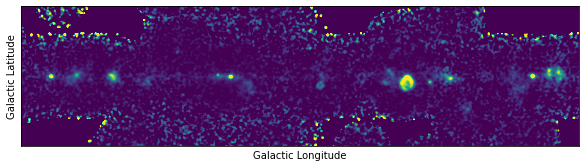

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt

with fits.open('hgps_map_flux_0.1deg_v1.fits') as HDU:
    print(HDU.info())
    image_data = HDU[0].data
    
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.imshow(image_data,origin='lower',vmin=0,vmax=6e-13)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

plt.xlim(3000,5000)

##alternatively, you can set the xlim of a specific axis
##by doing
#ax.set_xlim(3000,5000)

plt.show()
    

## World coordinate systems (WCS)
Right. Say you have this lovely gamma-ray image in Galactic $l,b$ coordinates, and you know there is some cool astrophysical object in there, but you only know it's RA/Dec. How can you easily plot this source on your galactic plane? The answer lies in getting a world coordinate system. This time, we turn to `astropy.wcs`, which lets us use information from the 'header' of a FITS file to create a coordinate system. First up, we use `astropy.wcs` to set up a world coordinate system. Read the comments and run the code to see what is going on:

In [5]:
from astropy.wcs import WCS

with fits.open('hgps_map_flux_0.1deg_v1.fits') as HDU:
    ##We use the header information of the primaru HDU
    ##to get a wcs object. We can use this to generate
    ##
    wcs = WCS(HDU[0].header)
    image_data = HDU[0].data
    
##One of the primary functions of the wcs is that
##you can find out the coordinate value (in this
##case the galactic longitude, latitude) of any
##pixel value in the image. Say we wanted to see
##the l,b value of the pixel x=4700, y=250:

##The final argument, the zero here, states that
##we want to use zero-based indexing, like the
##rest of python works

l,b = wcs.all_pix2world(4700, 250, 0)

print(l,b)

340.99 0.01


We have successfully found out the galactic coodinates of a single pixel, but we can easily find out and plot all of the coordinates using our old friend `np.meshgrid`:

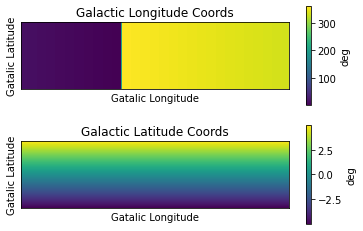

In [6]:
x_pixel_range = np.arange(9400)
y_pixel_range = np.arange(500)

x_mesh, y_mesh = np.meshgrid(x_pixel_range, y_pixel_range)

all_l, all_b = wcs.all_pix2world(x_mesh, y_mesh, 0)

##Setup two subplots. Remember that axs is an array
##of axes objects
fig, axs = plt.subplots(2,1)

##We are going to be setting
im_l = axs[0].imshow(all_l,origin='lower')
im_b = axs[1].imshow(all_b,origin='lower')

##We haven't used the zip command yet, but it's useful.
##It takes two or more arrays or lists, and zips them together
##so you have pairs of outputs, with the same index
##of each list/array being accessed. Basically means
##you can loop over two arrays/list simultaneously
##without having to remember which index you have gotten
##to. We'll use it here to create colorbars correctly

for ax, im in zip(axs,[im_l, im_b]):
    
    ##here, we set the xticks, yticks to be zero
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Gatalic Longitude')
    ax.set_ylabel('Gatalic Latitude')
    
    fig.colorbar(im,ax=ax,label='deg')
    
    ax.set_xlim(3000,5000)
    
##Note that instead of using set_xlim, we could
##slice the the data, i.e. all_l[:,3000:5000]
##to only plot a certain amount of data. However,
##the wcs we have setup is based on 9400 x pixels,
##so if you slice your data, the wcs no longer 
##matches it. So for this case, setting the plot
##limit makes more sense to retain the wcs
    
##add_title allows you to title each axes
axs[0].set_title('Galactic Longitude Coords')
axs[1].set_title('Galactic Latitude Coords')
plt.show()
plt.close()

As we are looking at the galactic plane here, we only have a small range of $b$, and we're looking towards the centre of the galaxy, so we wrap through $l=0^\circ$ and $l=360^\circ$. We can now use `SkyCoord` to convert these to RA/Dec:

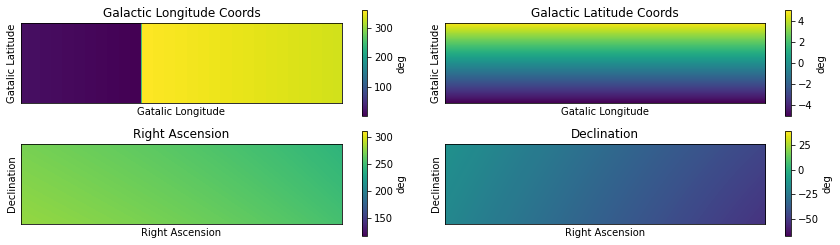

In [7]:
##Remember that all_l, all_b are our galactic coords
##that we generated with keywords from the FITS header
##Using the keyword 'frame' in the SkyCoord class
##allows us to declare we have Galactic coordsinates
coords_galactic = SkyCoord(all_l, all_b,unit='deg',frame='galactic')

##Here we transform from galactic in the 'fk5' frame
##The standard RA,Dec system is in the FK5 frame
coords_fk5 = coords_galactic.transform_to('fk5')

all_ras = coords_fk5.ra.deg
all_decs = coords_fk5.dec.deg

##Setup two subplots. Remember that axs is an array
##of axes objects. Here we ask for a 2 by 2 array of
##axes objects, so we access them as a 2 by 2 array
##below

##for this plot, the figsize=(12,3.5) command is
##important. As we are plotting 2D arrays that are longer
##in the horizontal vs. the vertical, to get everything
##to fit nicely, make the figure 12 wide and 3.5 high
##(try running again but deleting the figsize command)
fig, axs = plt.subplots(2,2,figsize=(12,3.5))

##do the same slice , and plot the l,b again
im_l = axs[0,0].imshow(all_l,origin='lower')
im_b = axs[0,1].imshow(all_b,origin='lower')

##do the same slice now for the ra, dec
im_ra = axs[1,0].imshow(all_ras,origin='lower')
im_dec = axs[1,1].imshow(all_decs,origin='lower')

##here is another useful command: flatten()
##this is an attribute of multi-dimensional array
##that turns it into a 1D array - useful for
##shoving into a zip like below:

for ax, im in zip(axs.flatten(),[im_l,im_b,im_ra,im_dec]):
    fig.colorbar(im,ax=ax,label='deg')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(3000,5000)
    
##Do a slice on the axs array to only add
##these labels to the top row, via a zip
for ax, im in zip(axs[0,:],[im_l,im_b]):
    ax.set_xlabel('Gatalic Longitude')
    ax.set_ylabel('Gatalic Latitude')
    
##Do a slice on the axs array to only add
##these labels to the bottom row, via a zip
for ax, im in zip(axs[1,:],[im_ra,im_dec]):
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    

##add_title allows you to title each axes
axs[0,0].set_title('Galactic Longitude Coords')
axs[0,1].set_title('Galactic Latitude Coords')
axs[1,0].set_title('Right Ascension')
axs[1,1].set_title('Declination')

##this is a somewhat stupid but necessary command that
##gets rid of white space and makes a subplot grid
##look nice. So we have to use it
plt.tight_layout()

plt.show()
plt.close()

## <font color='blue'>Exercise 4.3</font>
So, we have seen how to generate Galactic coordinates from a FITS header by using `wcs.all_pix2world`, and convert them into RA,Dec by using `SkyCoord.transform_to('fk5')`. We can do the opposite transform, to take RA,Dec into Galactic, and then into pixel values for this plot, by using `SkyCoord.transform_to('galactic')` and `wcs.all_world2pix`. Use the template below to take the RA,Dec location of the galactic centre and plot it over the HESS image, to see if there are any gamma rays coming out of it.


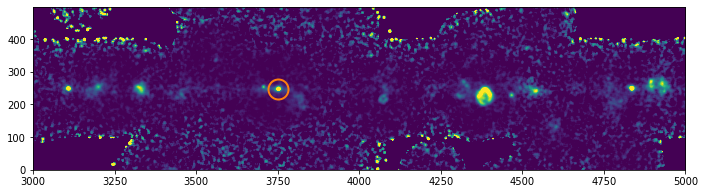

In [8]:
##Often coordinates are stored in this old school format
##but luckily astropy can handle it
gal_cent_ra = "17h45m40.04s"
gal_cent_dec = "-29d00m28.1s"

##make a SkyCoord of the galactic centre in FK5
cent_fk5 = SkyCoord(gal_cent_ra,gal_cent_dec)

##Here we transform from FK5 frame into galactic
cent_gal = cent_fk5.transform_to('galactic')

##need to know what x,y on our imshow image this
##coordinate matches to use wcs to find out
x_cent, y_cent = wcs.all_world2pix(cent_gal.l.deg, cent_gal.b.deg,0)

##only plotting one thing here, so quickest to just
##directly use plt. commands. Whether you use fig, axs
##or plt. is entirely up to you

plt.figure(figsize=(12,3))
plt.imshow(image_data,origin='lower',vmin=0,vmax=6e-13)

##There are a number of arguments here worth explaining:
## - the third argument here combines a colour (C1 is orange)
##   and a marker arugment (o means draw a circle)
## - mfc means marker face colour, and we set this to none so
##   that we only plot the edge of the circle
## - ms means marker size, which sets the overall size of the circle
## - mew means marker edge width, which sets the width of the
##   circle edge line that we plot
plt.plot(x_cent, y_cent, 'C1',marker='o',mfc='none',ms=20,mew=2.0)

plt.xlim(3000,5000)

plt.show()
plt.close()

Indeed you should see some gamma rays coming out of the galactic centre!

# But when?
Ok, so we now know how to convert between coordinate systems, and plot them over FITS files to highlight interesting spots. But what time of day are these interesting things overhead, for a given location on the sky? Astronomers need to know when to point their telescopes where to observe interesting sources. To do that, we need to understand Sidereal Time (ST). Check out this Wikipedia article [here](https://en.wikipedia.org/wiki/Sidereal_time) for a low-down on ST, but essentially it's a time system that is set so that for a given ST, a specific RA,Dec will appear at the same place on an observers sky. It's slightly different from the time on your phone or wrist watch (sometimes called Civil Time or Solar Time), as that is based on the Sun, rather than all of the stars.

Most important for observational astronomy is the Local Sidereal Time (LST), which depends on your longitude and latidude on the Earth, as well as the ST. You can use your location on the Earth and the date (in Civil Time) to calculate LST, which tells you exactly what RA is directly overhead at that time.

Let's situate ourselves where the Extremely Large Telescope (ELT, more info at this Wikipedia Article [here](https://en.wikipedia.org/wiki/Extremely_Large_Telescope) is being built in Chile, using `astropy.coordinates.EarthLocation`, and set the time using `astropy.time.Time`. Combining these two things can tell us the LST:

In [9]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

##The wikipedia article gives latitude as 24°35′21″S and 
##longitude as 70°11′30″W. S means South, which is a 
##negative latitude. W is West, but longitude is measured
##towards increasing East, so put is at negative here.
##We also put the altitude above sea level in, which can 
##effect atmospheric conditions, which is important to
##optical telescopes

ELT_location = EarthLocation(lat='-24d35m21s', lon='-70d11m30s', height=3046.0)

##Let's set a date. It's easiest (in my opinion) to set all
##times in UTC (Universal Time Coordinated), which doesn't
##change with daylight savings.
example_date = "2020-11-10 06:00:00"

##Create a Time instance at the given date and location
example_time = Time(example_date, scale='utc', location=ELT_location)

##Ok! Now we can calculate the LST. There are two options
##here, which are 'apparent' and 'mean'. I don't have space
##in the notebook to explain the difference. Google the difference,
##or ask me on the Friday wrap-up to explain the difference
##(and watch me squirm)
lst = example_time.sidereal_time('apparent')

print(lst)

4h38m39.4685s


Now we have an LST! For a given location, if you look directly up, it's called looking at 'zenith'. For a given time, zenith points towards an RA, Dec = LST, latitude. So we now know that looking at zenith, we see anything at an RA, Dec = 4h38m39.5s, -24d35m21s for this particular time and location on the Earth. As the Earth rotates, LST changes, and so what RA, Dec is overhead is constantly changing.

We can iterate over time, to see how LST changes, by using `astropy.time.TimeDelta` to increment our `Time` object:

In [10]:
from astropy.time import TimeDelta
import numpy as np

##remember, np.arange makes an array of numbers
##beginning with the first argument, incrementing
##by the 3rd argument, up to one increment
##before the 2nd argument.

##so for this example, it will make an array
##that starts at 0, incrementing by 3600,
##up to 82800. Here we are sampling every
##hour in seconds to see how LST changes

for time_delt in np.arange(0,24*60*60,60*60):
    
    ##As `example_time` is a Time Class, you need to change
    ##it using something that can interact with that class,
    ##so we set up a TimeDelta Class, which we create by feeding
    ##the number of seconds past example_time we want
    this_time = example_time + TimeDelta(time_delt, format='sec')
    
    ##As we have already set the Earth location of `example_time`
    ##this is remembered in `this_time`
    print(this_time.sidereal_time('apparent'))

4h38m39.4685s
5h38m49.3248s
6h38m59.1811s
7h39m09.0374s
8h39m18.8937s
9h39m28.75s
10h39m38.6063s
11h39m48.4625s
12h39m58.3188s
13h40m08.1751s
14h40m18.0314s
15h40m27.8876s
16h40m37.7439s
17h40m47.6001s
18h40m57.4564s
19h41m07.3126s
20h41m17.1689s
21h41m27.0251s
22h41m36.8814s
23h41m46.7376s
0h41m56.5938s
1h42m06.45s
2h42m16.3063s
3h42m26.1625s


This neatly demonstrates the difference between sidereal time, and civil (solar) time. You can see that LST increases slightly more than an hour, for every hour of civil time, as sidereal time isn't affected by the orbit of the Earth around the Sun, whereas Solar is.

## <font color='blue'>Exercise 4.4</font>
Make an `EarthLocation` at my favourite telescope, the Murchinson Widefield Array, which is at Latitude: -26.70331940$^\circ$, Longitude: 116.67081524$^\circ$, Height: 377m and call it `MWA_location`. `print` the LST for the same range of times by adapting the code overhead. You should see a differently list of LST as we're in a new location.

In [11]:
MWA_location = EarthLocation(lat=-26.70331940, lon=116.67081524, height=377.0)

##Let's set a date. It's easiest (in my opinion) to set all
##times in UTC (Universal Time Coordinated), which doesn't
##change with daylight savings.
example_date = "2020-11-10 06:00:00"

##Create a Time instance at the given date and location
MWA_example_time = Time(example_date, scale='utc', location=MWA_location)

for time_delt in np.arange(0,24*60*60,60*60):
    
    ##As `example_time` is a Time Class, you need to change
    ##it using something that can interact with that class,
    ##so we set up a TimeDelta Class, which we create by feeding
    ##the number of seconds past example_time we want
    this_time = MWA_example_time + TimeDelta(time_delt, format='sec')
    
    ##As we have already set the Earth location of `example_time`
    ##this is remembered in `this_time`
    print(this_time.sidereal_time('apparent'))

17h06m06.4641s
18h06m16.3205s
19h06m26.1768s
20h06m36.0331s
21h06m45.8893s
22h06m55.7456s
23h07m05.6019s
0h07m15.4582s
1h07m25.3145s
2h07m35.1707s
3h07m45.027s
4h07m54.8833s
5h08m04.7395s
6h08m14.5958s
7h08m24.4521s
8h08m34.3083s
9h08m44.1645s
10h08m54.0208s
11h09m03.877s
12h09m13.7333s
13h09m23.5895s
14h09m33.4457s
15h09m43.3019s
16h09m53.1581s


# Can we see it?
Right, there is one last coordinate system to understand, which is locked to the observer, and is called Azimuth and Altitude. Check out this image by TWCarlson from this Wikipedia article [here](https://en.wikipedia.org/wiki/Azimuth):

![436px-Azimuth-Altitude_schematic.svg.png](436px-Azimuth-Altitude_schematic.svg.png)

Azimuth and Altitude are defined relative to North and Zenith for a particular observer. Importantly, if an object has a postive Altitude, it means it's above the horizon, and we can see it. Higher elevations are typically better as there is less atmosphere to affect your observation (along with a few other reasons). We need one last piece of the puzzle, `astropy.coordinates.AltAz`, which we can use in conjuction with our `EarthLocation` and `Time`, to see when galaxy is visible. Let's check out when the [Large Magellanic Cloud](https://en.wikipedia.org/wiki/Large_Magellanic_Cloud), which is located at RA, Dec = 05h23m34.5s, -69d45m22s, is visible to the LST:

In [12]:
from astropy.coordinates import AltAz

##See above for explanations - duplicating here for clarity
ELT_location = EarthLocation(lat='-24d35m21s', lon='-70d11m30s', height=3046.0)

example_date = "2020-11-10 06:00:00"

example_time = Time(example_date, scale='utc', location=ELT_location)

##Set up a sky coordinate for the LMC at the correct RA, Dec
LMC = SkyCoord('05h23m34.5s', '-69d45m22s')

##Create an AltAz class based on our observing location and date
##This can then be use to calculate Altitude and Azimuth for
##a given SkyCoord(s) - essentially we are creating a new frame,
##that we can use to transform a SkyCoord with
altaz_ELT = AltAz(obstime=example_time,location=ELT_location)

##We then use our LMC SkyCoord.transform_to attribute
##to transform the RA,Dec in Alt, Az
altaz_LMC = LMC.transform_to(altaz_ELT)

##This will show there is plenty of stuff going on
##under the hood here
print(altaz_LMC)

##We just want azimuth and altitude
print('Azimuth is',altaz_LMC.az.deg,'deg')
print('Altitude is',altaz_LMC.alt.deg,'deg')

<SkyCoord (AltAz: obstime=2020-11-10 06:00:00.000, location=(1967462.25449585, -5462343.77373646, -2639029.12993265) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (174.59902531, 44.3716657)>
Azimuth is 174.59902531466093 deg
Altitude is 44.371665700139935 deg


So the LMC is above the horizon and visibile at this time. With the first `print` statement, you can see there are many things that `AltAz` is capable of taking into account, like pressure, temp, relative_humidity etc. These can all effect image quality for an optical telescope. We won't go into them here. Especially as I'm a radio astronomer so I don't know about them.

What I _do_ know, is that we can increment our time, and calculate Altitude against time to see when things are above the horizon:

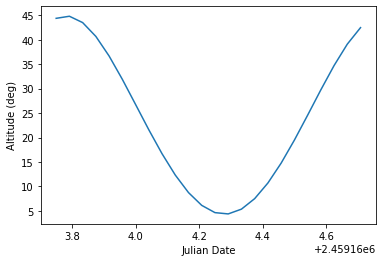

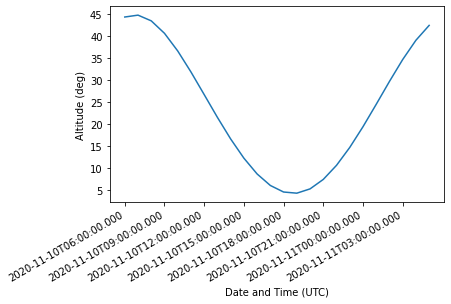

In [13]:

##Here, we are cutting out a for loop, and feeding an array
##directly into TimeDelta
tdelts = TimeDelta(np.arange(0,24*60*60,60*60), format='sec')

##Add out delta times onto our example time
all_times = example_time + tdelts

##Now we can just feed all of our times to make AzAlt 
##calculations for multiple times
altazs_ELT = AltAz(obstime=all_times,location=ELT_location)

##LMC is an RA/Dec which doesn't change with time (over a night)
##so feeding it multiple AltAz frames can do multiple conversions
altazs_LMC = LMC.transform_to(altazs_ELT)

##That's it! Let's plot Altitude against Time
##Here I'm using all_times.jd which plots the
##Julian date - the numbers are easier for matplotlib
##to make something sensible on the plot
plt.plot(all_times.jd,altazs_LMC.alt.deg)
plt.xlabel('Julian Date')
plt.ylabel('Altitude (deg)')

##show the plot, then close down the current figure
plt.show()
plt.close()


##---Slightly advanced bit here for the interested----

##This time I'm using all_time.fits, which formats
##the time into how it appears in the header of a
##FITS image file
plt.plot(all_times.fits,altazs_LMC.alt.deg)

##This makes many long date strings which overlap
##Here, I'm setting the xticks, which means the
##where the numbers or strings on the axis are marked
##I'm using arange to sample every third time value
##to cut down on the time values
plt.xticks(all_times.fits[np.arange(0,len(all_times),3)])

##Further to that, this command gets current figure (gcf)
##and then auto-formats the date to be angled, making it
##easier to read
plt.gcf().autofmt_xdate()

plt.xlabel('Date and Time (UTC)')
plt.ylabel('Altitude (deg)')

plt.show()
plt.close()


So at this time of year, the LMC is _always_ above the horizon for the ELT. 

## <font color=blue>Exercise 4.5</font>
Make a simlar plot of Altitude vs. Time by adapting the code above, but plot the three following sources, all on the same plot. Set the ylim to 0$^\circ$ to 90$^\circ$, because we can't see below the horizon.

 Source         | RA        | Dec      
----------------|-----------|----------
Tarantula Nebula | 05h38m38s | -69d05m42s
Triangulum Galaxy| 01h33m50s | +30d39m37s
Lagoon Nebula    | 18h3m37s  | -24d23m12s


<font color=red>Optional extension</font>: use the `label` keywork of `plot` to add legend information, and then add a legend so you know which object is whic

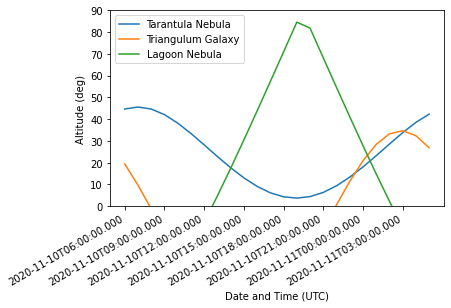

In [14]:
from astropy.coordinates import AltAz

##See above for explanations - duplicating here for clarity
ELT_location = EarthLocation(lat='-24d35m21s', lon='-70d11m30s', height=3046.0)
example_date = "2020-11-10 06:00:00"

##Again, time over 24 hours, every hour
tdelts = TimeDelta(np.arange(0,24*60*60,60*60), format='sec')

##Add out delta times onto our example time
all_times = example_time + tdelts

##Create an AltAz class based on our observing location and date
##This can then be use to calculate Altitude and Azimuth for
##a given SkyCoord(s) - essentially we are creating a new frame,
##that we can use to transform a SkyCoord with
altazs_ELT = AltAz(obstime=all_times,location=ELT_location)


ras = ['05h38m38s','01h33m50s','18h3m37s']
decs = ['-69d05m42s','+30d39m37s','-24d23m12s']
labels = ['Tarantula Nebula','Triangulum Galaxy','Lagoon Nebula']

##use zip to iterate over all the lists of inputs in one 
##convnenient foul swoop
for ra, dec, label in zip(ras, decs, labels):
    ##Set up a sky coordinate for the correct RA, Dec
    coord = SkyCoord(ra,dec)

    ##use the altazs_ELT to covert our ra/dec coord
    ##into alt/az at the ELT
    altazs = coord.transform_to(altazs_ELT)

    plt.plot(all_times.fits, altazs.alt.deg, label=label)
    
plt.ylim(0,90)

plt.legend()
    
##play the same trick as before to get better xticks
plt.xticks(all_times.fits[np.arange(0,len(all_times),3)])
plt.gcf().autofmt_xdate()

##ALWAYS LABEL YOUR AXES
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Altitude (deg)')

plt.show()